# Tutorial 07 - Convolutional Neural Networks

## Cats vs Dogs
Dataset can be downloaded from http://files.fast.ai/data/dogscats.zip  
Classification to 2 classes  
Basic setup as before:

In [1]:
import numpy as np
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: " + str(torch.cuda.is_available()) + " Count: " + str(torch.cuda.device_count()))

Device: True Count: 1


In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
root_dir = '../data/dogscats/train'

target_size = (32, 32)
transforms = Compose([Resize(target_size), # Resizes image
                    ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset = ImageFolder(root_dir, transform=transforms)

In [3]:
len(train_dataset)

23000

In [4]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

In [5]:
# Same for validation dataset
val_root_dir = '../data/dogscats/valid'
val_dataset = ImageFolder(val_root_dir, transform=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print(len(val_dataset))

2000


print(len(val_dataset))

# Baseline - MLP model
### We will compare MLP and ConvNets in terms of accuracy, number of parameters, etc.

from utils_train import fit

In [6]:
from utils_train import fit
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [7]:
model_mlp = MLPModel(32*32*3, 128)
model_mlp = model_mlp.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
n_epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [8]:
curves_mlp = fit(train_dataloader, val_dataloader, model_mlp, optimizer, loss_fn, n_epochs)

Training iteration 0: loss 0.6935
Training iteration 100: loss 0.6838
Training iteration 200: loss 0.6508
Training iteration 300: loss 0.6335
Training iteration 400: loss 0.6071
Training iteration 500: loss 0.5839
Training iteration 600: loss 0.7087
Training iteration 700: loss 0.6009
Test average loss: 0.6390, accuracy: 63.050
Epoch 1/5: train_loss: 0.6524, train_accuracy: 60.9087, val_loss: 0.6390, val_accuracy: 63.0500
Training iteration 0: loss 0.6596
Training iteration 100: loss 0.5686
Training iteration 200: loss 0.7198
Training iteration 300: loss 0.6781
Training iteration 400: loss 0.6163
Training iteration 500: loss 0.6226
Training iteration 600: loss 0.6632
Training iteration 700: loss 0.6022
Test average loss: 0.6253, accuracy: 65.100
Epoch 2/5: train_loss: 0.6219, train_accuracy: 65.2087, val_loss: 0.6253, val_accuracy: 65.1000
Training iteration 0: loss 0.6503
Training iteration 100: loss 0.4985
Training iteration 200: loss 0.6515
Training iteration 300: loss 0.6347
Traini

### With some regularization the best accuracy we got before for this MLP model was ~68%

## Convolutional Neural Network
### Two convolutions with Max Pooling, followed by linear layer on flattened feature maps

In [9]:
import torch.nn as nn
    
class ConvModel(nn.Module):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3x32x32
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
            # output: 16x28x28 (because kernel_size=5 and no padding)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 16x14x14
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            # output: 32x10x10
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 32x5x5
        )
        self.linear_layer = nn.Linear(32*5*5, 2) # map output of conv layers to number of outputs (2 classes in this case)
    
    def forward(self, input):
        output = self.conv_layers(input) # NO FLATTENING HERE, expected input is of dimension batch_size x n_channels x im_height x im_width
        output = output.view(output.size(0), 32*5*5) # Flatten to a vector before passing to a linear layer
        output = self.linear_layer(output)
        return output

In [10]:
model_conv = ConvModel()
model_conv = model_conv.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate)
n_epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [11]:
curves_conv1 = fit(train_dataloader, val_dataloader, model_conv, optimizer, loss_fn, n_epochs)

Training iteration 0: loss 0.6749
Training iteration 100: loss 0.7006
Training iteration 200: loss 0.6627
Training iteration 300: loss 0.8456
Training iteration 400: loss 0.6046
Training iteration 500: loss 0.7996
Training iteration 600: loss 0.5690
Training iteration 700: loss 0.5284
Test average loss: 0.5708, accuracy: 71.000
Epoch 1/5: train_loss: 0.6237, train_accuracy: 64.7348, val_loss: 0.5708, val_accuracy: 71.0000
Training iteration 0: loss 0.5248
Training iteration 100: loss 0.5907
Training iteration 200: loss 0.4593
Training iteration 300: loss 0.6713
Training iteration 400: loss 0.5403
Training iteration 500: loss 0.4888
Training iteration 600: loss 0.6069
Training iteration 700: loss 0.5217
Test average loss: 0.5331, accuracy: 74.450
Epoch 2/5: train_loss: 0.5447, train_accuracy: 72.6739, val_loss: 0.5331, val_accuracy: 74.4500
Training iteration 0: loss 0.4964
Training iteration 100: loss 0.4939
Training iteration 200: loss 0.6276
Training iteration 300: loss 0.6737
Traini

In [12]:
import torch.nn as nn
    
class ConvModel2(nn.Module):
    
    def __init__(self):
        super(ConvModel2, self).__init__()
        self.conv_layers = nn.Sequential(
            # input size: 3x32x32
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
            # output: 16x28x28 (because kernel_size=5 and no padding)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 16x14x14
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            # output: 32x10x10
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 32x5x5
            nn.AvgPool2d(kernel_size=5, stride=5) # alternatively: AdaptiveAvgPool(1)
        )
        self.linear_layer = nn.Linear(32, 2)
    
    def forward(self, input):
        output = self.conv_layers(input)
        output = output.view(output.size(0), 32)
        output = self.linear_layer(output)
        return output

In [13]:
model_conv2 = ConvModel2()
model_conv2 = model_conv2.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model_conv2.parameters(), lr=learning_rate)
n_epochs = 5
loss_fn = nn.CrossEntropyLoss()

In [14]:
curves_conv2 = fit(train_dataloader, val_dataloader, model_conv2, optimizer, loss_fn, n_epochs)

Training iteration 0: loss 0.7061
Training iteration 100: loss 0.6418
Training iteration 200: loss 0.6376
Training iteration 300: loss 0.5289
Training iteration 400: loss 0.6476
Training iteration 500: loss 0.6065
Training iteration 600: loss 0.6319
Training iteration 700: loss 0.6235
Test average loss: 0.6268, accuracy: 65.200
Epoch 1/5: train_loss: 0.6592, train_accuracy: 60.7522, val_loss: 0.6268, val_accuracy: 65.2000
Training iteration 0: loss 0.5987
Training iteration 100: loss 0.6398
Training iteration 200: loss 0.7438
Training iteration 300: loss 0.5894
Training iteration 400: loss 0.6454
Training iteration 500: loss 0.5894
Training iteration 600: loss 0.4880
Training iteration 700: loss 0.5322
Test average loss: 0.5933, accuracy: 69.200
Epoch 2/5: train_loss: 0.6138, train_accuracy: 66.2087, val_loss: 0.5933, val_accuracy: 69.2000
Training iteration 0: loss 0.5206
Training iteration 100: loss 0.6212
Training iteration 200: loss 0.5605
Training iteration 300: loss 0.5291
Traini

# Compare number of parameters

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
print('MLP: {} parameters'.format(count_parameters(model_mlp)))
print('ConvNet1: {} parameters'.format(count_parameters(model_conv)))
print('ConvNet2: {} parameters'.format(count_parameters(model_conv2)))

MLP: 426626 parameters
ConvNet1: 15650 parameters
ConvNet2: 14114 parameters


__Model MLP__:
- 1st layer: (32 * 32 * 3)*128 + 128 (biases) __// input size dependant, 92% of parameters!__
- 2nd layer: 128 * 128 + 128
- 3rd layer: 128 * 128 + 128
- 4th layer: 128 * 2 + 2

__Model ConvNet1__:
- 1st layer (conv): 16 * 3 * 5 * 5 + 16 (biases)
- 2nd layer (conv): 32 * 16 * 5 * 5 + 32
- 3rd layer (linear): (32 * 5 * 5) * 2 + 2 __// input size dependant__ <- can grow very big for bigger input size and large number of filters

__Model ConvNet2__:
- 1st layer (conv): 16 * 3 * 5 * 5 + 16 (biases)
- 2nd layer (conv): 32 * 16 * 5 * 5 + 32
- 3rd layer (linear): 32 * 2 + 2  
^ Independent of input size (average pool must be set accordingly)

# First conv layer filter visualization
## What does the network look for in the raw image?

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

### Example: AlexNet, trained on ImageNet dataset (>1 million images, 1000 classes) https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

In [18]:
import torchvision
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\nalet/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth


In [19]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
filters = alexnet.features[0].weight.detach().cpu().numpy()

In [21]:
filters.shape

(64, 3, 11, 11)

In [22]:
filters = filters.transpose(0, 2, 3, 1)

In [23]:
filters_ = filters.copy()

In [24]:
for i in range(len(filters_)):
    filters_[i] -= np.min(filters_[i])
    filters_[i] /= np.max(filters_[i])

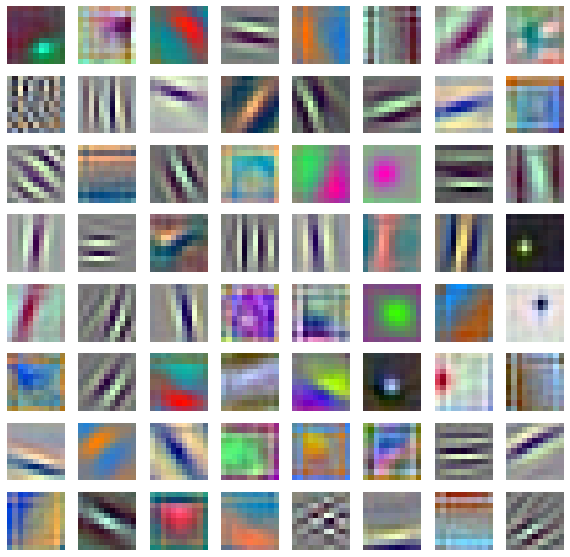

In [25]:

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    axes[i // 8][i % 8].imshow(filters_[i], cmap='gray')
    axes[i // 8][i % 8].axis('off')